## Homework 8
Submitted by Sriniketh Shankar

t = 1, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032
t = 5, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032
t = 10, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032
t = 20, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032
t = 40, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032
t = 80, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032
t = 160, x* = [ 0.14449998  0.99       -0.13449997], f0(x*) = 10.08301369710032


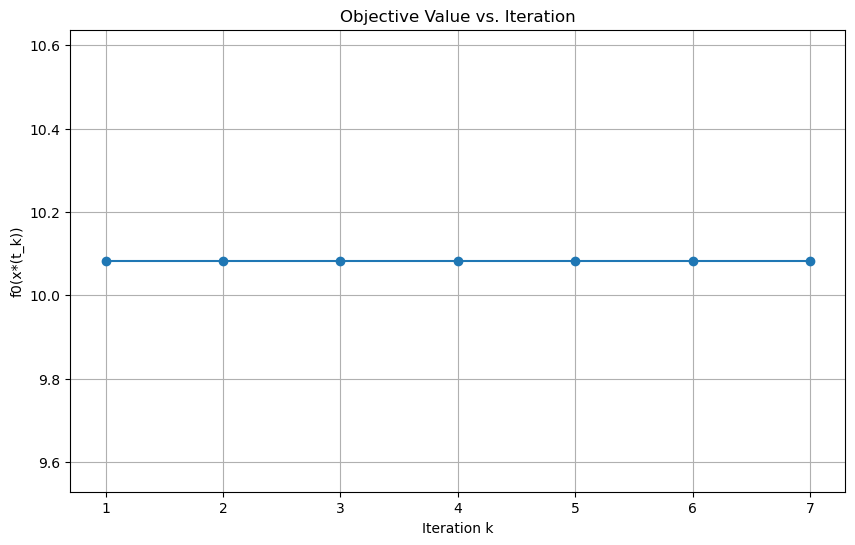


Final solution:
x* = [ 0.14449998  0.99       -0.13449997]
f0(x*) = 10.08301369710032

Constraint verification:
Sum of x: 1.0000000000000002 (should be 1)
Ax - b: [-4.47052235e-08 -8.25149878e-01] (should be <= 0)
Box constraints: all x_i in [-0.13449997426916646, 0.9899999978205022] (should be in [-1, 1])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Problem data
P = np.array([
    [5, 4, 6],
    [4, 9, 15],
    [6, 15, 35]
])

q = np.array([5, 7, 6])

A = np.array([
    [4, 0.9, 2],
    [1.3, 0.6, 6]
])

b = np.array([1.2, 0.8])

# Objective function: (1/2)x^T Px + q^T x
def f0(x):
    return 0.5 * x.T @ P @ x + q.T @ x

# Gradient of objective function
def grad_f0(x):
    return P @ x + q

# Hessian of objective function
def hessian_f0(x):
    return P

# Barrier function approach
def barrier_function(x, t):
    # Original objective
    obj = t * f0(x)
    
    # Inequality constraints: Ax <= b
    for i in range(len(b)):
        val = b[i] - A[i] @ x
        if val <= 0:
            return np.inf
        obj -= np.log(val)
    
    # Box constraints: -1 <= x <= 1
    for xi in x:
        val1 = 1 - xi  # x <= 1
        val2 = xi + 1  # -1 <= x
        if val1 <= 0 or val2 <= 0:
            return np.inf
        obj -= np.log(val1) - np.log(val2)
    
    return obj

# Gradient of the barrier function
def grad_barrier(x, t):
    grad = t * grad_f0(x)
    
    # Inequality constraints: Ax <= b
    for i in range(len(b)):
        val = b[i] - A[i] @ x
        grad += A[i] / val
    
    # Box constraints: -1 <= x <= 1
    for j in range(len(x)):
        val1 = 1 - x[j]  # x <= 1
        val2 = x[j] + 1  # -1 <= x
        grad[j] += 1 / val1
        grad[j] -= 1 / val2
    
    return grad

# Hessian of the barrier function
def hessian_barrier(x, t):
    H = t * hessian_f0(x)
    
    # Inequality constraints: Ax <= b
    for i in range(len(b)):
        val = b[i] - A[i] @ x
        H += np.outer(A[i], A[i]) / (val**2)
    
    # Box constraints: -1 <= x <= 1
    for j in range(len(x)):
        val1 = 1 - x[j]  # x <= 1
        val2 = x[j] + 1  # -1 <= x
        H[j, j] += 1 / (val1**2)
        H[j, j] += 1 / (val2**2)
    
    return H

def solve_barrier_subproblem(x0, t):
    # Define the equality constraint: 1^T x = 1
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Optimization
    result = minimize(
        lambda x: barrier_function(x, t),
        x0,
        method='SLSQP',  # Using SLSQP to handle equality constraint
        constraints=[eq_constraint],
        bounds=[(-0.99, 0.99) for _ in range(len(x0))]  # Staying inside feasible region
    )
    
    return result.x

# Initial feasible point (satisfying all constraints)
def find_initial_point():
    # Start with x = [1/3, 1/3, 1/3] to satisfy 1^T x = 1
    x0 = np.array([1/3, 1/3, 1/3])
    
    # Check all constraints
    constraints_satisfied = True
    
    # Check Ax <= b
    for i in range(len(b)):
        if A[i] @ x0 > b[i]:
            constraints_satisfied = False
            break
    
    # Check -1 <= x <= 1 (already satisfied for this x0)
    
    if constraints_satisfied:
        return x0
    else:
        # Find a feasible point by solving a feasibility problem
        def feasibility_obj(x):
            penalty = 0
            for i in range(len(b)):
                penalty += max(0, A[i] @ x - b[i])**2
            return penalty
        
        eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = [(-0.99, 0.99) for _ in range(3)]
        
        result = minimize(feasibility_obj, x0, method='SLSQP', constraints=[eq_constraint], bounds=bounds)
        return result.x

# Barrier method
def barrier_method():
    # Parameters for the barrier method
    t_values = [1, 5, 10, 20, 40, 80]  # Initial t values
    mu = 2  # Factor to increase t
    epsilon = 1e-6  # Convergence tolerance
    
    # Find initial feasible point
    x = find_initial_point()
    
    # Results storage
    optimal_points = []
    objective_values = []
    
    # Run for specified t values
    for t in t_values:
        x = solve_barrier_subproblem(x, t)
        optimal_points.append(x)
        objective_values.append(f0(x))
        print(f"t = {t}, x* = {x}, f0(x*) = {f0(x)}")
    
    # Continue with additional t values until convergence
    t = t_values[-1]
    while True:
        t *= mu
        x = solve_barrier_subproblem(x, t)
        optimal_points.append(x)
        current_obj = f0(x)
        objective_values.append(current_obj)
        print(f"t = {t}, x* = {x}, f0(x*) = {current_obj}")
        
        # Check for convergence
        if len(objective_values) >= 2:
            if abs(objective_values[-1] - objective_values[-2]) < epsilon:
                break
        
        # Prevent infinite loops
        if len(objective_values) > 15:
            break
    
    return optimal_points, objective_values, t_values + [t * (mu**i) for i in range(len(objective_values) - len(t_values))]

# Run the barrier method
optimal_points, objective_values, all_t_values = barrier_method()

# Plot f0(x*(t)) vs iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(objective_values) + 1), objective_values, 'o-')
plt.xlabel('Iteration k')
plt.ylabel('f0(x*(t_k))')
plt.title('Objective Value vs. Iteration')
plt.grid(True)
plt.show()

# Final solution
final_x = optimal_points[-1]
final_obj = objective_values[-1]
print("\nFinal solution:")
print(f"x* = {final_x}")
print(f"f0(x*) = {final_obj}")

# Verify constraints
print("\nConstraint verification:")
print(f"Sum of x: {np.sum(final_x)} (should be 1)")
print(f"Ax - b: {A @ final_x - b} (should be <= 0)")
print(f"Box constraints: all x_i in [{min(final_x)}, {max(final_x)}] (should be in [-1, 1])")